# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30888,41798,86750,"Dublin City, Ireland",11-04-2020,They tell me you re the only person I ve spoke...,Positive
21358,29853,74805,USA,01-04-2020,No #Coronavirus Break for Consumer #CreditScor...,Positive
28548,38835,83787,"Dade City, FL",08-04-2020,"We wanna hear your best Covid-19 Joke, because...",Extremely Positive
10133,16096,61048,NaN,21-03-2020,People are STILL panic buying shit. I've heard...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
emotions = df['Sentiment'].tolist()
set(emotions)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Positive'}

In [ ]:
df = df.replace(['Extremely Negative','Negative','Extremely Positive','Positive'],[0,0,1,1])

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [ ]:
zeros=df.loc[df['Sentiment']==0,'Sentiment'].count()
edinicas=df.loc[df['Sentiment']==1,'Sentiment'].count()
print("Наибольшая разница между классами: ", 100-int(min(zeros,edinicas)/max(zeros,edinicas)*100 + 0.5),"%")

Наибольшая разница между классами:  15 %


**Ответ:** *Так как процент довольно мал, то можно считать, что классы сбалансированны*

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
df.isnull().any()

UserName         False
ScreenName       False
Location          True
TweetAt          False
OriginalTweet    False
Sentiment        False
dtype: bool

In [ ]:
#Пропуски только в локациях
df['Location'].fillna('Unknown', inplace=True)

In [ ]:
df.isnull().any() #Теперь пропусков нет

UserName         False
ScreenName       False
Location         False
TweetAt          False
OriginalTweet    False
Sentiment        False
dtype: bool

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split
s = np.random.seed(42)
train, test = train_test_split(df, test_size=0.3,random_state=s)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
from nltk.probability import FreqDist

nltk.download('punkt',quiet=True)
fdist = FreqDist()
for raw in train['OriginalTweet']:
  for i in raw.split():
    fdist[i.lower()] += 1

Какой размер словаря получился?

In [ ]:
print(len(fdist))

79513


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
fdist.most_common(10)

[('the', 26772),
 ('to', 23480),
 ('and', 14566),
 ('of', 13053),
 ('a', 11537),
 ('in', 11201),
 ('for', 8541),
 ('#coronavirus', 8168),
 ('is', 7396),
 ('are', 6898)]

**Ответ:** В целом тут содержатся только предлоги, хештег коронавируса (ведь посты про коронавирус) и глагол to be. Просто самые популярные слова в любом английском тексте

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


fdist_without_stop = fdist.copy()
for i in fdist.keys():
  if i in stop_words:
    del fdist_without_stop[i]

fdist_without_stop.most_common(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('#coronavirus', 8168),
 ('prices', 3895),
 ('food', 3845),
 ('grocery', 3425),
 ('supermarket', 3278),
 ('covid-19', 3174),
 ('store', 3171),
 ('people', 3142),
 ('#covid19', 2483),
 ('consumer', 2262)]

**Ответ:** Без стоп-слов больше слов, которые относятся к главным темам постов/твитов. По ним можно отследить самые популярные проблемы/темы и так далее.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
print(list(reversed(fdist_without_stop.most_common()))[:20])

[('https://t.co/i2wsgmzxtg', 1), ('https://t.co/ksnz52unrv', 1), ('enraging!!', 1), ('https://t.co/1ioo4mlmzc', 1), ('islands,', 1), ('https://t.co/1whyfial70', 1), ('link,', 1), ('debt"', 1), ('"surviving', 1), ('.@nclc4consumers', 1), ('https://t.co/cywvxl4hzx', 1), ('https://t.co/x3nflaebnk', 1), ('"unavoidable"', 1), ('outflows', 1), ('aq:', 1), ('@mauriciocard', 1), ("colombia's", 1), ('https://t.co/f62lteprso', 1), ('https://t.co/vsiiwruts7', 1), ('https://t.co/jbykncmrxf', 1)]


**Ответ:** По большей части они содержат лишь локальные ссылки или слова с ошибками/пропусками пробелов/пунктуацией, поэтому они не повторяются. Так как для нас они не несут особой информации, дополнительно работать с ними не нужно и их нужно убрать



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

tk = TweetTokenizer()
tweettokens = FreqDist()
for raw in train['OriginalTweet']:
  for i in tk.tokenize(raw):
    tweettokens[i.lower()] += 1

tweettokens.most_common(10)

[('the', 26956),
 ('.', 23945),
 ('to', 23587),
 (',', 17430),
 ('and', 14709),
 ('of', 13082),
 ('a', 11680),
 ('in', 11342),
 ('?', 9725),
 ('#coronavirus', 8727)]

**Ответ:** Теперь, кроме предлогов, добавилась ещё и пунктуация

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

tokens_without_stop = tweettokens.copy()
for i in tweettokens.keys():
  if i in stop_words or i in punctuation:
    del tokens_without_stop[i]

tokens_without_stop.most_common(10)

[('#coronavirus', 8727),
 ('â', 7272),
 ('\x82', 7165),
 ('19', 7146),
 ('covid', 6211),
 ('prices', 4603),
 ('food', 4411),
 ('\x92', 4301),
 ('store', 3862),
 ('supermarket', 3819)]

**Ответ:** Теперь, кроме слов, тут отдельные символы и числа, которые не являются словами

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
tokens = tokens_without_stop.copy()
for i in tokens_without_stop.keys():
  if len(i)==1 and ord(i)>=128:
    del tokens[i]

tokens.most_common(10)

[('#coronavirus', 8727),
 ('19', 7146),
 ('covid', 6211),
 ('prices', 4603),
 ('food', 4411),
 ('store', 3862),
 ('supermarket', 3819),
 ('grocery', 3481),
 ('people', 3418),
 ('#covid19', 2593)]

In [ ]:
print(list(reversed(tokens.most_common()))[:20])

[('https://t.co/i2wsgmzxtg', 1), ('https://t.co/ksnz52unrv', 1), ('https://t.co/1ioo4mlmzc', 1), ('https://t.co/1whyfial70', 1), ('https://t.co/cywvxl4hzx', 1), ('https://t.co/x3nflaebnk', 1), ('outflows', 1), ('aq', 1), ('@mauriciocard', 1), ("colombia's", 1), ('https://t.co/f62lteprso', 1), ('https://t.co/vsiiwruts7', 1), ('https://t.co/jbykncmrxf', 1), ('karwick', 1), ("al's", 1), ("#al's", 1), ('hickey', 1), ('https://t.co/dhj10u2kso', 1), ('#stopprofiteering', 1), ('opportunism', 1)]


**Ответ:** # Теперь в топе самых популярных только слова, имющие смысл. По большей части они совпадают (пусть и не по порядку) с предыдущим топом, однако в данном случае в топе есть число, которое пусть и относится к теме, но может мешать. Однако, так как нам не мешала пунктуация, лучше видна частота использования токенов.

Самые непопулярные слова остались примерно в той же категории: ссылки, локальеы темы, юзернеймы

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
h=[(j,tokens[j]) for j in tokens.keys() if j.startswith('#')]
h=sorted(h,key=lambda x:x[1],reverse=True)[:10]
for i in h:
  print(i[0]+": "+str(i[1]))

#coronavirus: 8727
#covid19: 2593
#covid_19: 1724
#covid2019: 947
#toiletpaper: 753
#covid: 636
#socialdistancing: 468
#coronacrisis: 446
#pandemic: 245
#coronaviruspandemic: 244


**Ответ:** Почти все эти хештеги содержат названия темы, поэтому понятно, почему они самые популярные

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
t=[(j,tokens[j]) for j in tokens.keys() if j.startswith('https://t.co')]
t=sorted(t,key=lambda x:x[1],reverse=True)[:10]
for i in t:
  print(i[0]+": "+str(i[1]))

https://t.co/3kfuiojxep: 4
https://t.co/r7sagojsjg: 4
https://t.co/wrlhyzizaa: 4
https://t.co/oi39zsanq8: 3
https://t.co/gp3eusapl8: 3
https://t.co/kuwipf1kqw: 3
https://t.co/za8rewpvvb: 3
https://t.co/6yvykiab2c: 3
https://t.co/xpcm2xkj4o: 3
https://t.co/pe99mhrsat: 3


**Ответ:** Ссылки, в целом, не важны для нашего анализа, так как они редко используются и обычно не повторяются. Хештеги созданы для того, чтобы пользователь отфильтровал свою "ленту" и читал твиты по определенной теме. Ссылки же могут дополнить пост автора, но чаще всего у всех они разные и повторений мало

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  tk = TweetTokenizer()
  tokens = []
  for i in tk.tokenize(text):
    if i not in punctuation and not (len(i)==1 and ord(i.lower())>=128) and i.lower() not in stop_words and not i.lower().startswith('https://t.co'):
      tokens.append(i.lower())

  return tokens


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45180


In [ ]:
print(len(fdist_without_stop))
print(len(tokens))

79341
57973


**Ответ:** Размер словаря, полученный самым простым токенайзером, был в два раза больше нынешнего. Позже, убрав стоп слова и пунктуацию, мы получили словари меньше

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Reading a ?@TorontoStar? article about grocery shopping&amp;prices during covid-19, and a line stands out: Ã\x82Â\x93Last week, PusateriÃ\x82Â\x92s ... selling $30 container of disinfectant wipes went viralÃ\x82Â\x94 &amp; IÃ\x82Â\x92m shocked. That was just last week? Feels like last month! https://t.co/lWyDuug6LX',
 1)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
cv_france = cv.transform([train.iloc[ind]['OriginalTweet']])
all_tokens = cv.get_feature_names_out()
f_array = cv_france.toarray()
print('самый важный:',all_tokens[f_array.argmax()])
f_array2=f_array.copy()
f_array2[f_array2 ==0]=f_array.argmax()
print('наименее важный:', all_tokens[f_array2.argmin()])

самый важный: last
наименее важный: ...


**Ответ:** Вышли токены, которые не несут какого-то определенного смысла. По ним тяжело определить целевую переменную

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(tokenizer=custom_tokenizer)
tfv.fit_transform(train['OriginalTweet'])

tfv_f = tfv.fit_transform([train.iloc[ind]['OriginalTweet']])
all_tokens_tfv = tfv.get_feature_names_out()
tfv_array = tfv_f.toarray()
print('самый важный:', all_tokens_tfv[tfv_array.argmax()])


tfv_array2=tfv_array.copy()
tfv_array2[tfv_array2 ==0]=tfv_array.argmax()
print('наименее важный:', all_tokens_tfv[tfv_array2.argmin()])

самый важный: last
наименее важный: ...


**Ответ:** Дорогой дневник, мне не подобрать слов, чтобы описать боль и унижение, через которые я прошла, пока делала эти два задания. Я сидела над этим 5 часов, чтобы ничего не поменялось, я сдаюсь

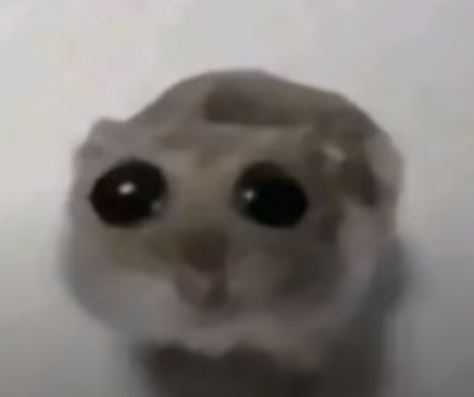

In [ ]:
from IPython.display import Image
Image('грустьитоска.JPG')

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
23318,32289,77241,"Dublin City, Ireland",04-04-2020,Healthcare workers are amazing during this #CO...,1
30115,40794,85746,INDIA,10-04-2020,1 Sanitizer 2 Italy 3 Wuhan 4 Grocery Join for...,1
21308,29789,74741,Unknown,01-04-2020,@pulte My family and I need money for grocerie...,1
11674,17953,62905,Essex,21-03-2020,Thank you so much @waitrose you have been amaz...,1
19919,28079,73031,"Newbury, Berkshire, UK",26-03-2020,The amazing and have managed to get production...,1
...,...,...,...,...,...,...
4696,9504,54456,"Birmingham, UK",19-03-2020,"Our Lord has made other foods available to us,...",1
26020,35674,80626,"Basingstoke, Hampshire, UK",07-04-2020,We want to say a HUGE thank you to all the key...,1
5158,10067,55019,"South West, England",19-03-2020,Next series of supermarket sweep is going to b...,1
18667,26521,71473,Unknown,25-03-2020,Please all give a shout out to our amazing sup...,1


In [ ]:
ind = 23318
df.iloc[ind]['OriginalTweet'], df.iloc[ind]['Sentiment']

("Healthcare workers are amazing during this #COVID2019 pandemic but please let's not forget how amazing our Supermarket workers, chemists workers, Binmen, delivery drivers and distribution works playing a major part in keeping life going. But Healthcare is gettin all the praise",
 1)

In [ ]:
tfv = TfidfVectorizer(tokenizer=custom_tokenizer)
tfv.fit_transform(train['OriginalTweet'])

tfv_f = tfv.fit_transform([df.iloc[ind]['OriginalTweet']])
all_tokens_tfv = tfv.get_feature_names_out()
tfv_array = tfv_f.toarray()
print('самый важный:', all_tokens_tfv[tfv_array.argmax()])

самый важный: workers


**Ответ:** Это наиболее повторяющееся слово в этом посте, определяющее главную тему твита.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
X_train,y_train = train['OriginalTweet'],train['Sentiment']
X_test,y_test = test['OriginalTweet'],test['Sentiment']

cv_train = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

tfv_train = tfv.fit_transform(X_train)
tfv_test = tfv.transform(X_test)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(cv_train, y_train)
print("С CountVectorizer")
print("Доля правильных ответов на обучающей выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_train),y_train)))
print("Доля правильных ответов на тестовой выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_test),y_test)))

clf.fit(tfv_train, y_train)
print("С TfidfVectorizer")
print("Доля правильных ответов на обучающей выборке: {0:.5f}".format(accuracy_score(clf.predict(tfv_train),y_train)))
print("Доля правильных ответов на тестовой выборке: {0:.5f}".format(accuracy_score(clf.predict(tfv_test),y_test)))

С CountVectorizer
Доля правильных ответов на обучающей выборке: 0.98419
Доля правильных ответов на тестовой выборке: 0.87283
С TfidfVectorizer
Доля правильных ответов на обучающей выборке: 0.92623
Доля правильных ответов на тестовой выборке: 0.84901


**Ответ:** # Как можно заметить, CountVectorizer дал лучший результат на обеих выборках. Он смотрит на тональность именно отдельного "документа", независимо от общего сбора, а TfidfVectorizer наоборот. Именно поэтому TfidfVectorizer хуже для нас, так как некоторые слова не имеют особого значения для определения негативного/позитивного смысла, однако часто встречаются в общем корпусе текстов, из-за чего он даёт им ошибочную важность

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer('english')
  tk = TweetTokenizer()
  tokens = []
  for i in tk.tokenize(text):
    if i not in punctuation and not (len(i)==1 and ord(i.lower())>=128) and i.lower() not in stop_words and not i.lower().startswith('https://t.co'):
      tokens.append(stemmer.stem(i.lower()))
  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit_transform(X_train)
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36550


**Ответ** # Предыдущий размер словаря был 45 тысяч, то есть сильно больше, чем сейчас

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
cv_train = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

tfv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfv_train = tfv.fit_transform(X_train)
tfv_test = tfv.transform(X_test)

clf.fit(cv_train, y_train)
print("С CountVectorizer")
print("Доля правильных ответов на обучающей выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_train),y_train)))
print("Доля правильных ответов на тестовой выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_test),y_test)))

clf.fit(tfv_train, y_train)
print("С TfidfVectorizer")
print("Доля правильных ответов на обучающей выборке: {0:.5f}".format(accuracy_score(clf.predict(tfv_train),y_train)))
print("Доля правильных ответов на тестовой выборке: {0:.5f}".format(accuracy_score(clf.predict(tfv_test),y_test)))

С CountVectorizer
Доля правильных ответов на обучающей выборке: 0.97125
Доля правильных ответов на тестовой выборке: 0.87502
С TfidfVectorizer
Доля правильных ответов на обучающей выборке: 0.91559
Доля правильных ответов на тестовой выборке: 0.86157


**Ответ:** # Результаты почти не изменились, для CountVectorizer даже стали немного хуже. Для TfidfVectorizer тоже результаты почти те же, только на обучающей выборке стали хуже, а на тестовой лучше. Поэтому можно сделать вывод, что есть смысл применять стемминг

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [101]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000
                        ).fit(
                            X_train
                            )
print(len(cv_df.vocabulary_))

36549


In [102]:
cv_train = cv_df.fit_transform(X_train)
cv_test = cv_df.transform(X_test)

clf.fit(cv_train, y_train)
print("С CountVectorizer")
print("Доля правильных ответов на обучающей выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_train),y_train)))
print("Доля правильных ответов на тестовой выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_test),y_test)))

С CountVectorizer
Доля правильных ответов на обучающей выборке: 0.97117
Доля правильных ответов на тестовой выборке: 0.87532


**Ответ:** # Большой, так как не попали все те токены, что используются больше 7000 раз. По итоге, на обеих выборках результат немного лучше, но почти также

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [103]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            X_train
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3719


In [104]:
cv_train = cv_df.fit_transform(X_train)
cv_test = cv_df.transform(X_test)

clf.fit(cv_train, y_train)
print("С CountVectorizer")
print("Доля правильных ответов на обучающей выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_train),y_train)))
print("Доля правильных ответов на тестовой выборке: {0:.5f}".format(accuracy_score(clf.predict(cv_test),y_test)))

С CountVectorizer
Доля правильных ответов на обучающей выборке: 0.92969
Доля правильных ответов на тестовой выборке: 0.87094


**Ответ:** # Мы убираем те токены, которые встречаются реже 11 раз. Если взять порог 10, то будет 3900+-, а если больше, то 3500+-. Качество осталось примерно таким же, совсем немного ухудшилось

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [106]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
sc_train= sc.fit_transform(cv_train)
sc_test = sc.transform(cv_test)

clf.fit(sc_train, y_train)
print("Доля правильных ответов на обучающей выборке: {0:.5f}".format(accuracy_score(clf.predict(sc_train),y_train)))
print("Доля правильных ответов на тестовой выборке: {0:.5f}".format(accuracy_score(clf.predict(sc_test),y_test)))

Доля правильных ответов на обучающей выборке: 0.94284
Доля правильных ответов на тестовой выборке: 0.84792


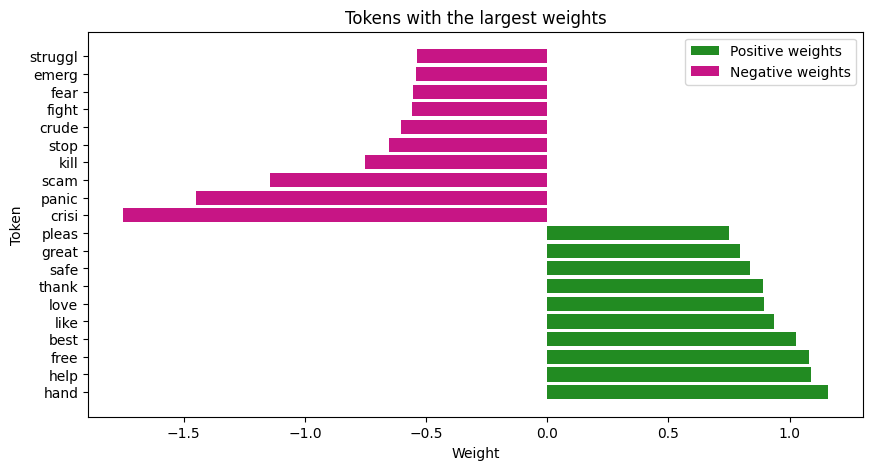

In [115]:
weights = clf.coef_[0]
indexes = [(weights[i],i) for i in range(len(weights))]
weights_abs = sorted(indexes, key=lambda x: abs(x[0]), reverse=True)

positive = [i[0] for i in weights_abs if i[0]>0][:10]
negative = [i[0] for i in weights_abs if i[0]<0][:10]

p_ind = [i[1] for i in weights_abs if i[0]>0][:10]
n_ind = [i[1] for i in weights_abs if i[0]<0][:10]
tokens_p = [cv_df.get_feature_names_out()[i] for i in p_ind]
tokens_n = [cv_df.get_feature_names_out()[i] for i in n_ind]

plt.figure(figsize=(10, 5))
plt.barh(tokens_p, positive, label='Positive weights',color='forestgreen')
plt.barh(tokens_n, negative, label='Negative weights', color='mediumvioletred')
plt.xlabel('Weight')
plt.ylabel('Token')
plt.title('Tokens with the largest weights')
plt.legend()
plt.show()

**Ответ:** Это все эмоциональные слова/сленг, поэтому видно, что модель верно определяет тональность

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [118]:
#Для того, чтобы они были полезны, у нас должна быть взаимосвязь с целевой переменной. Для этого они должны повторяться и много раз, проверим это

print(df.shape)
print(len(df['UserName'].unique()))
print(len(df['ScreenName'].unique()))

(33444, 6)
33444
33444


**Ответ:** Как можно заметить, ничего не повторяется, а значит нам эти признаки не нужны

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

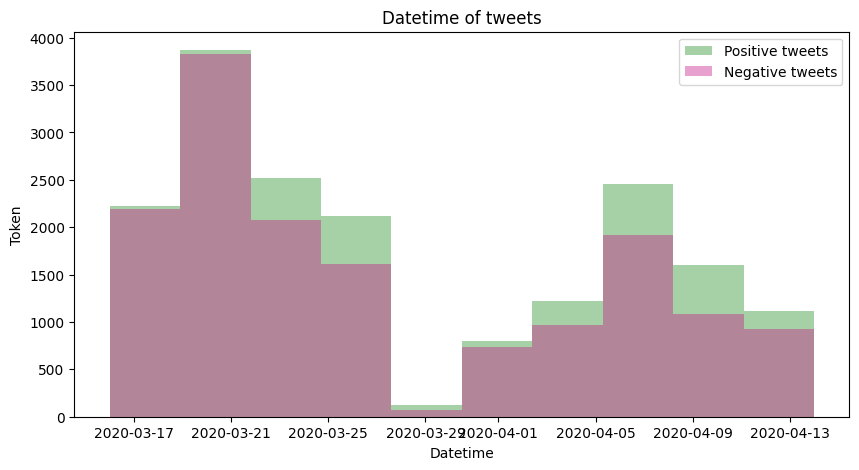

In [121]:
df['TweetAt']=pd.to_datetime(df['TweetAt'])

positive = df.loc[df['Sentiment']==1,'TweetAt']
negative = df.loc[df['Sentiment']==0,'TweetAt']

plt.figure(figsize=(10, 5))
plt.hist(positive, label='Positive tweets',color='forestgreen',alpha=0.4)
plt.hist(negative, label='Negative tweets', color='mediumvioletred',alpha=0.4)
plt.xlabel('Datetime')
plt.ylabel('Token')
plt.title('Datetime of tweets')
plt.legend()
plt.show()

**Ответ:** Как можно заметить, они примерно одинаковые, целевая переменная не зависит от времени, а значит признак нам не нужен



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [122]:
print(len(df['Location'].unique()))

10465


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

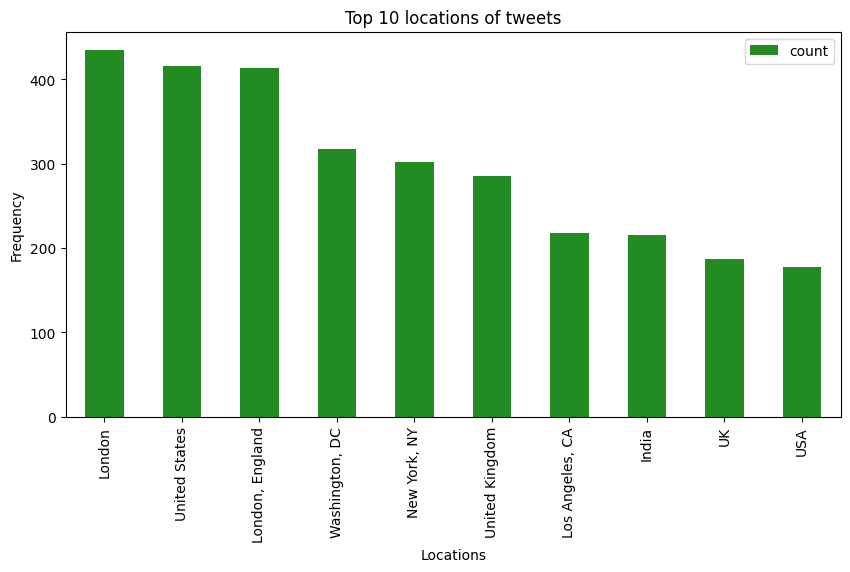

In [145]:
loc = (df.loc[df['Location']!='Unknown','Location'].value_counts())[:10]

plt.figure(figsize=(10, 5))
loc.plot(kind='bar',color='forestgreen')
plt.xlabel('Locations')
plt.ylabel('Frequency')
plt.title('Top 10 locations of tweets')
plt.legend()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [132]:
df['WiderLocation'] = df.loc[:, 'Location']


In [141]:
for i in range(df.shape[0]):
  if ',' in df['WiderLocation'][i]:
    s=df['WiderLocation'][i].split(",")[-1].strip()
    df['WiderLocation'][i]=s

print(len(df['WiderLocation'].unique()))

6305


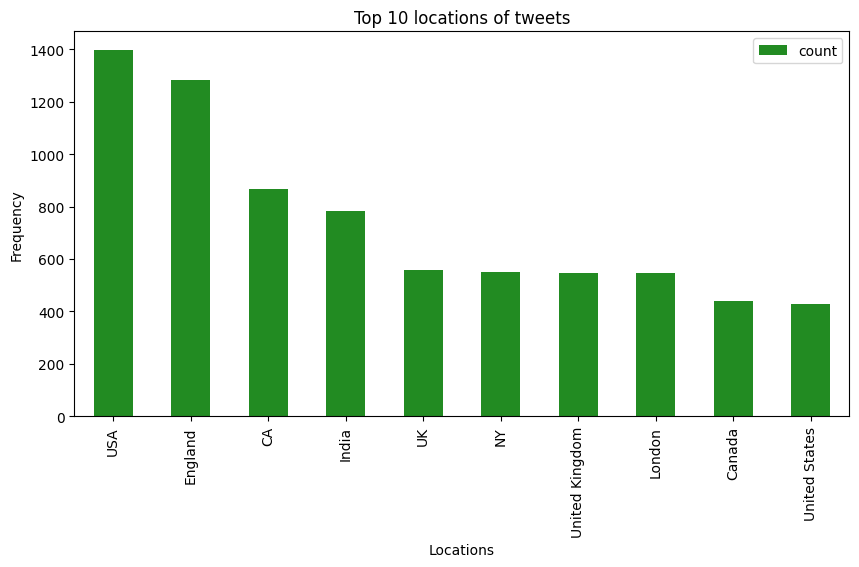

In [144]:
loc = (df.loc[df['WiderLocation']!='Unknown','WiderLocation'].value_counts())[:10]

plt.figure(figsize=(10, 5))
loc.plot(kind='bar',color='forestgreen')
plt.xlabel('Locations')
plt.ylabel('Frequency')
plt.title('Top 10 locations of tweets')
plt.legend()
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --